In [19]:
import torch
import numpy as np
from torchvision.transforms import transforms as T
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
sys.path.append('..')
sys.path.append('../dataset_loader')
sys.path.append('../model')
from evaluation.evaluation_utils import post_processing, compute_metrics_global, model_inference, compute_metrics, \
    unsupervised_post_processing,  compute_metrics_unsupervised
from config import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from dataset_loader.image_loader import *
from model.resunet import *
from utils import *

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
#'../model_results/weakly_supervised_ae/yellow/c-resunet_y_ws_ae/'
'../model_results/supervised/yellow/c-resunet_y_11/'

'../model_results/weakly_supervised_ae/yellow/c-resunet_y_ws_ae/'

In [6]:
path = '../model_results/supervised/yellow/c-resunet_y_11/'

In [7]:
for ix,m in enumerate(os.listdir(path)):
    print(ix,m)

0 c-resunet_y_11.h5
1 metrics
2 summary


In [8]:
model_name = os.listdir(path)[0]
print(model_name)

c-resunet_y_11.h5


In [9]:
from_ae = False #to replace ae with binary inference
ae = False
ae_bin= False #without removing ae capability
ae_fine_tuned = False

c0=True

In [10]:
if from_ae:
    resume_path = ModelResults + model_name 
    model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start=16, n_out=1).to(device))

    layers_to_remove = ['module.head.conv2d.weight', 'module.head.conv2d.bias']
    layers_to_rename = ['module.head.conv2d_binary.weight', 'module.head.conv2d_binary.bias']
    checkpoint_file = torch.load(resume_path)
    for k in list(checkpoint_file.keys()):
        if k in layers_to_remove:
            checkpoint_file.pop(k)
    for k in list(checkpoint_file.keys()):
        if k in layers_to_rename:
            checkpoint_file[k.replace("_binary", "")] = checkpoint_file.pop(k)
    model.load_state_dict(checkpoint_file, strict=False)  
    
else:
    if ae:
        model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16, n_out = 3,
                pretrained = False, progress= True)).to(device)
        print('autoencoder')
        model.load_state_dict(torch.load(path+'{}'.format(model_name)))
    elif ae_bin:
        model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16,ae_bin=True, n_out = 3,
                pretrained = False, progress= True)).to(device)
        model.load_state_dict(torch.load(path + '{}'.format(model_name)))
    elif ae_fine_tuned:
        model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16,ae_bin=True, n_out = 1,
                pretrained = False, progress= True)).to(device)
        model.load_state_dict(torch.load(path +'{}'.format(model_name)))
        
    else:
        model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16, n_out = 1,c0=c0,
                pretrained = False, progress= True)).to(device)
        model.load_state_dict(torch.load(path + '{}'.format(model_name)))

including c0 in the network
Initializing conv2d weights with Kaiming He normal


In [11]:
test = True
dataset = 'yellow'

In [13]:
if dataset == 'blu':
    transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                           T.ToTensor(),
                           #T.Resize((1040,1400))
                           T.CenterCrop((1000, 1400))
                          #T.Lambda(lambda x: x.permute(2, 0, 1))
                           ])
else:
    transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       #T.Resize((1040,1400))
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])

if dataset == 'yellow':
    priority_list = []
    #priority_list = ['254.tiff', '275.tiff', '81.tiff', '278.tiff', '279.tiff', '281.tiff', '273.tiff'
    #                ,'50.tiff']
    cells_images = CellsLoader(root + "/DATASET/test/all_images/images/",
                               root + "/DATASET/test/all_masks/masks/", 
                               val_split=0.3, transform = transform, test = test, 
                               priority_list=priority_list)
    
elif dataset == 'blu':
    cells_images = CellsLoader(root + "/DATASET/test/all_images/blu/",
                               root + "/DATASET/test/all_masks/blu/", 
                               val_split=0.3, transform = transform, test = test)
    
elif dataset == 'green':
    cells_images = CellsLoader(str(Path(root).parent.as_posix()) + "/weakly_supervised_cell_segmentation/data/test/original_images/",
                               str(Path(root).parent.as_posix()) + "/weakly_supervised_cell_segmentation/data/test/original_masks/", 
                               val_split=0.3, transform = transform, test = test)
    
elif dataset == 'red':
    priority_list = []
    cells_images = CellsLoader(root + "/DATASET/fine_tuning/red/test/all_images/images/",
                               root + "/DATASET/fine_tuning/red/test/all_masks/masks/", 
                               val_split=0.3, transform = transform, test = test)

In [14]:
#cells_images = CellsLoader(root + "/DATASET/train_val/crop_augmented/images/",
#                           root + "/DATASET/train_val/crop_augmented/masks/", 
#                           val_split=0.3, transform = transform, ae = ae, test = False)

batch_size = 8
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [15]:
x, y = next(iter(test_loader))

In [16]:
model.eval()
with torch.no_grad():
    heatmap = model(x.to(device))
    #heatmap = 1 - heatmap

In [ ]:
save = False

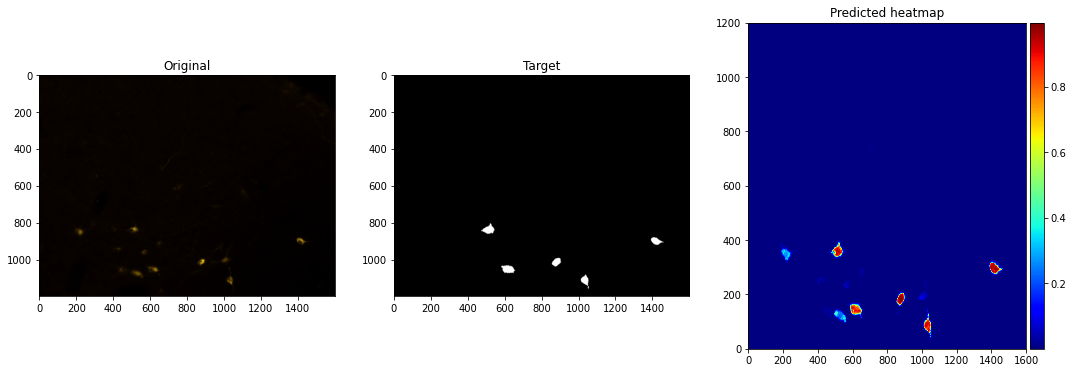

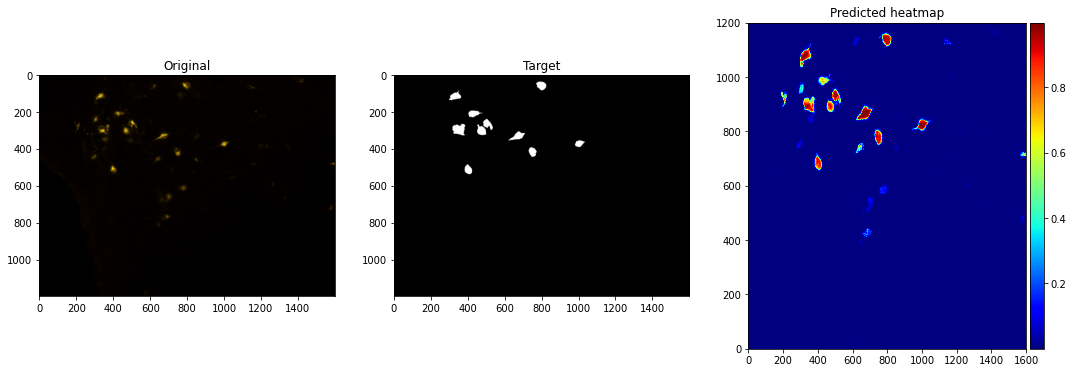

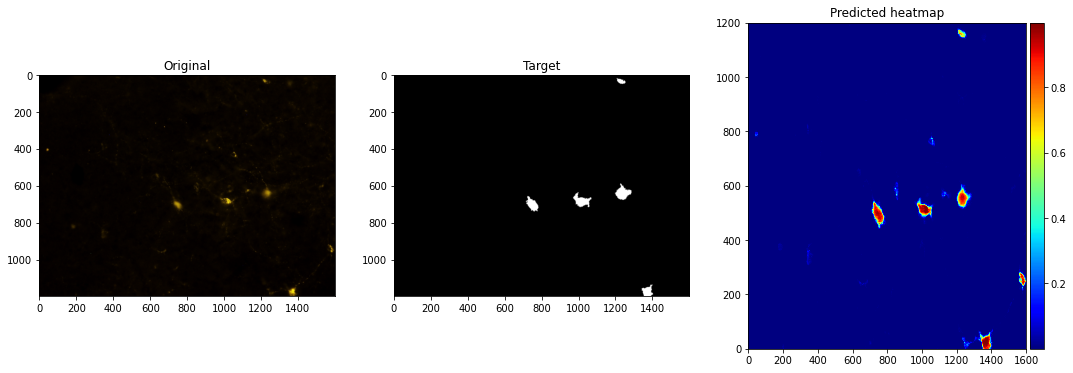

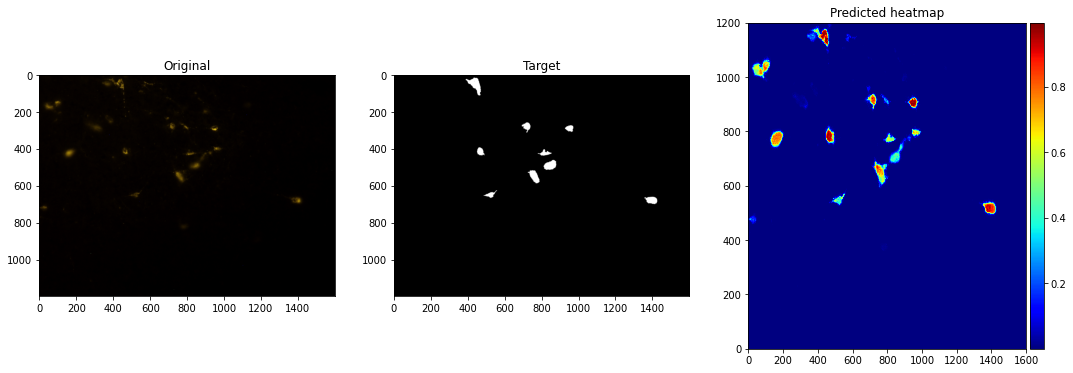

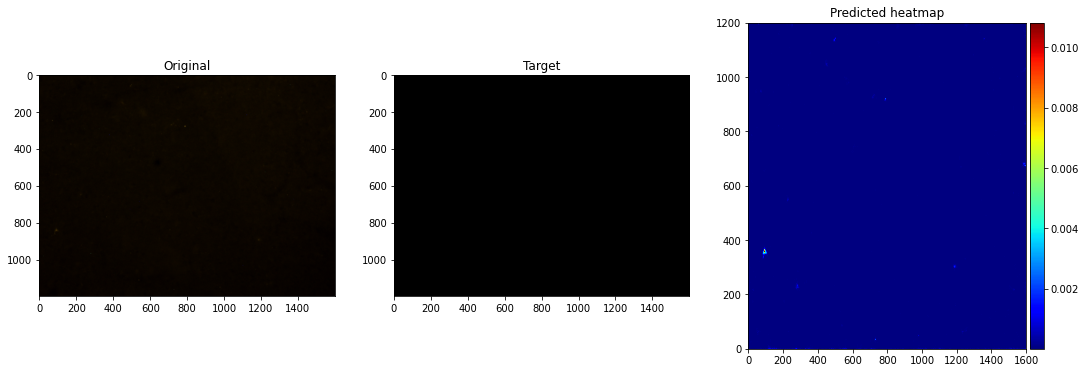

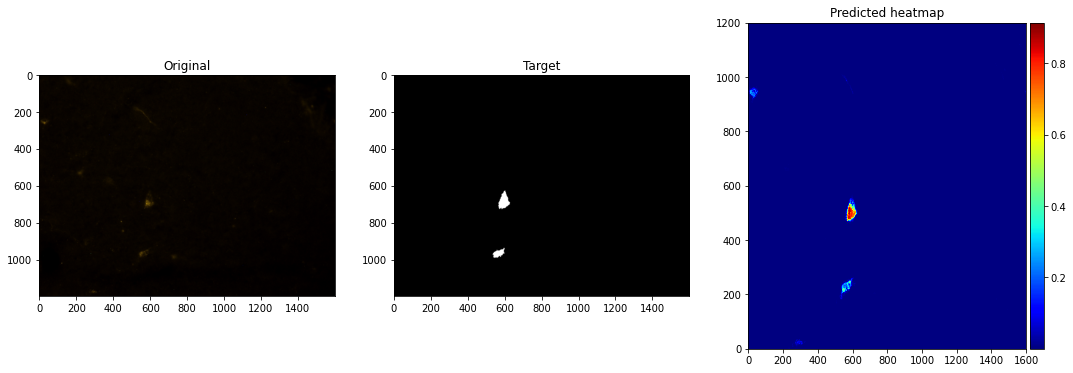

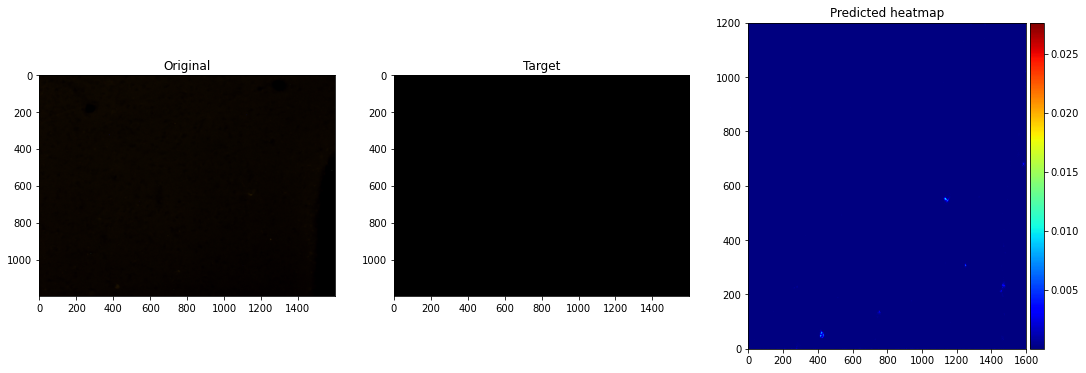

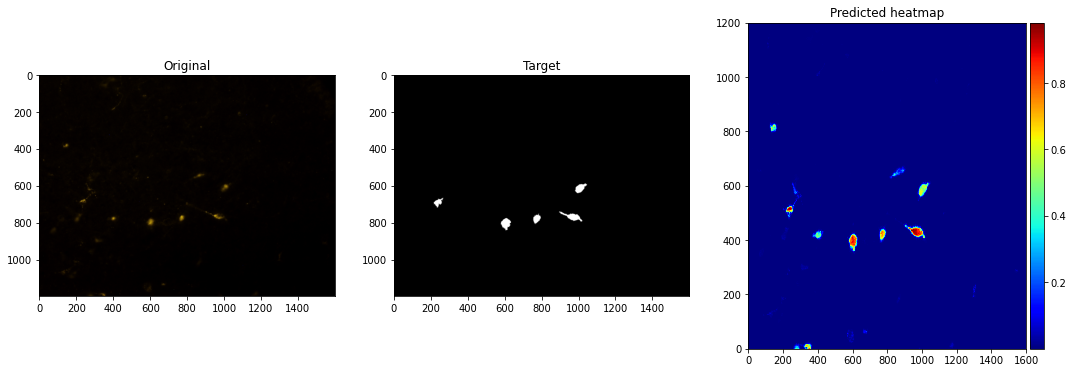

In [18]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    heat_map = heatmap[i]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
       
    im = axes[0].imshow(original)
    axes[0].set_title('Original')


    if heat_map.shape[0]==3:
        im = axes[1].imshow(original)
        axes[1].set_title('Target')
    
        im = axes[2].imshow(heat_map.cpu().permute(1,2,0))
        axes[2].set_title('reconstructed')
        
    else:
        im = axes[1].imshow(np.squeeze(target), cmap='gray')
        axes[1].set_title('Target')
    

        im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
        divider = make_axes_locatable(axes[2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        axes[2].set_title('Predicted heatmap') 
    
    if save:
        if os.path.exists('../figure_results/{}/{}'.format(model_name.split('.')[0], dataset)):
            print('path alredy exixts')
        else:
            os.makedirs('../figure_results/{}/{}'.format(model_name.split('.')[0], dataset))
        
        plt.savefig('../figure_results/{}/{}/{}_{}.png'.format(model_name.split('.')[0], \
                                                               dataset, model_name.split('.')[0],i))

In [56]:
from_ae = False #to replace ae with binary inference
ae = False
ae_bin= False #without removing ae capability
ae_fine_tuned = False

In [57]:
if from_ae:
    resume_path = ModelResults + model_name 
    model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start=16, n_out=1).to(device))

    layers_to_remove = ['module.head.conv2d.weight', 'module.head.conv2d.bias']
    layers_to_rename = ['module.head.conv2d_binary.weight', 'module.head.conv2d_binary.bias']
    checkpoint_file = torch.load(resume_path)
    for k in list(checkpoint_file.keys()):
        if k in layers_to_remove:
            checkpoint_file.pop(k)
    for k in list(checkpoint_file.keys()):
        if k in layers_to_rename:
            checkpoint_file[k.replace("_binary", "")] = checkpoint_file.pop(k)
    model.load_state_dict(checkpoint_file, strict=False)  
    
else:
    if ae:
        model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16, n_out = 3,
                pretrained = False, progress= True)).to(device)
        model.load_state_dict(torch.load('../model_results/{}'.format(model_name)))
    elif ae_bin:
        model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16,ae_bin=True, n_out = 3,
                pretrained = False, progress= True)).to(device)
        model.load_state_dict(torch.load('../model_results/{}'.format(model_name)))
    elif ae_fine_tuned:
        model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16,ae_bin=True, n_out = 1,
                pretrained = False, progress= True)).to(device)
        model.load_state_dict(torch.load('../model_results/{}'.format(model_name)))
        
    else:
        model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16, n_out = 1,
                pretrained = False, progress= True)).to(device)
        model.load_state_dict(torch.load('../model_results/{}'.format(model_name)))

including c0 in the network
Initializing conv2d weights with Kaiming He normal


IsADirectoryError: [Errno 21] Is a directory: '../model_results/fine_tuning'

In [9]:
heatmap = torch.load('yellowed_red.pt')

In [12]:
model.eval()
with torch.no_grad():
    heatmap_post = model(heatmap.to(device))

In [21]:
test = True
dataset = 'red'

In [22]:
transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       #T.Resize((1040,1400))
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])

In [23]:
if dataset == 'yellow':
    priority_list = ['254.tiff', '275.tiff', '81.tiff', '278.tiff', '279.tiff', '281.tiff', '273.tiff'
                    ,'50.tiff']
    cells_images = CellsLoader(root + "/DATASET/test/all_images/images/",
                               root + "/DATASET/test/all_masks/masks/", 
                               val_split=0.3, transform = transform, test = test, 
                               priority_list=priority_list)
elif dataset == 'red':
    priority_list = []
    cells_images = CellsLoader(root + "/DATASET/fine_tuning/red/test/all_images/images/",
                               root + "/DATASET/fine_tuning/red/test/all_masks/masks/", 
                               val_split=0.3, transform = transform, test = test)

#cells_images = CellsLoader(root + "/DATASET/train_val/crop_augmented/images/",
#                           root + "/DATASET/train_val/crop_augmented/masks/", 
#                           val_split=0.3, transform = transform, ae = ae, test = False)

batch_size = 8
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [24]:
x, y = next(iter(test_loader))

In [28]:
dataset='yellowe_red'
save=True

In [1]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    heat_map = heatmap_post[i]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
       
    im = axes[0].imshow(original)
    axes[0].set_title('Original')

    im = axes[1].imshow(np.squeeze(target), cmap='gray')
    axes[1].set_title('Target')

    im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    axes[2].set_title('Predicted heatmap') 
    
    
    if save:
        if os.path.exists('../figure_results/{}/{}'.format(model_name.split('.')[0], dataset)):
            print('path alredy exixts')
        else:
            os.makedirs('../figure_results/{}/{}'.format(model_name.split('.')[0], dataset))
        
        plt.savefig('../figure_results/{}/{}/{}_{}.png'.format(model_name.split('.')[0], \
                                                               dataset, model_name.split('.')[0],i))

NameError: name 'heatmap' is not defined